<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Представити початковi данi графiчно.
2. Розбити данi на навчальний та валiдацiйний набори.

3. Побудувати на навчальному наборi даних моделi класифiкацiї або регре-
сiї заданi згiдно з варiантом.

4. Представити моделi графiчно (наприклад вивести частину дерева рi-
шень, побудувати лiнiю регресiї тощо).

5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.

7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.

9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi методу опорних векторiв:<br><br>
• Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. <br>
  Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.<br><br>
• Настроїти гiперпараметри epsilon i C, використовуючи решітчастий пошук.<br><br>
Початковi данi:<br>
(а) https://www.kaggle.com/datasets/bogof666/shanghai-car-license-plate-auction-price <br>


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------
# Завантажити набір даних
from pathlib import Path

# --- Constructing a robust Path that works in notebooks and scripts ---
# Attempt to locate the project root (IAD) by walking up from this file's directory
try:
    # If running as a script, __file__ is available
    script_path = Path(__file__).resolve()
    script_dir = script_path.parent
except NameError:
    # If running in a notebook, use the notebook's working directory as a best-effort fallback
    script_dir = Path.cwd()

# Try to find the repo root by looking for the 'IAD' folder in parents or using a heuristic
iad_dir = None
for p in [script_dir] + list(script_dir.parents):
    if p.name.lower() == 'iad' or (p / 'lab_2').exists():
        iad_dir = p
        break
if iad_dir is None:
    # Fallback: assume script_dir parent is project root
    iad_dir = script_dir.parent

# Path to data directory (IAD/lab_2/data)
data_dir = iad_dir / 'lab_2' / 'data'

# --- Loading the Dataset ---
# Specify your dataset filename
# The user indicated the file: 'Shanghai license plate price - Sheet3.csv'
dataset_name = 'Shanghai license plate price - Sheet3.csv'

file_path = data_dir / dataset_name

# Try a few common variations (different encodings / BOM / alternative names)
candidates = [file_path,
              data_dir / 'Shanghai license plate price.csv',
              data_dir / 'Shanghai license plate price - Sheet1.csv',
              data_dir / dataset_name.replace(' ', '_'),
              data_dir / dataset_name.replace(' - Sheet3', '')]

# Deduplicate while preserving order
seen = set()
candidates = [p for p in candidates if not (str(p) in seen or seen.add(str(p)))]

loaded = False
for p in candidates:
    try:
        print(f"Attempting to load data from: {p}")
        # Try utf-8 first, then cp1251 and latin1 if utf-8 fails
        try:
            df = pd.read_csv(p)
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(p, encoding='cp1251')
            except Exception:
                df = pd.read_csv(p, encoding='latin1')
        print("Data loaded successfully from:", p)
        loaded = True
        break
    except FileNotFoundError:
        print(f"File not found at: {p}")
    except pd.errors.EmptyDataError:
        print(f"File at {p} is empty or invalid CSV.")
    except Exception as e:
        print(f"Failed to load {p}: {e}")

if not loaded:
    raise FileNotFoundError(f"Could not find or load dataset. Checked {len(candidates)} paths.\nLooked for: {[str(x) for x in candidates]}")

# Normalize column names
if 'df' in globals():
    df.columns = df.columns.astype(str).str.strip()
    
    # Показати імена стовпців
    print("Стовпці датасету:")
    print(df.columns.tolist())
    print("\n")

    # Показати інформацію про датасет
    print("Інформація про датасет:")
    df.info()
    print("\n")

    # Показати описові статистики
    print("Описові статистики:")
    print(df.describe())
    print("\n")

    # Перевірити відсутні значення
    print("Відсутні значення:")
    print(df.isnull().sum())
    print("\n")

    # Перетворити стовпець 'Date' у datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')

    # Показати перші рядки датасету
    print("Перші 5 рядків датасету:")
    print(df.head())
    print("\n")




Attempting to load data from: d:\anaconda\Projects\IAD\lab_2\data\Shanghai license plate price - Sheet3.csv
Data loaded successfully from: d:\anaconda\Projects\IAD\lab_2\data\Shanghai license plate price - Sheet3.csv
Стовпці датасету:
['Date', 'Total number of license issued', 'lowest price', 'avg price', 'Total number of applicants']


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Date                            204 non-null    object
 1   Total number of license issued  204 non-null    int64 
 2   lowest price                    204 non-null    int64 
 3   avg price                       204 non-null    int64 
 4   Total number of applicants      204 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.1+ KB


Описові статистики:
       Total number of license issued  lo

Дані чисті, без пропусків. Статистики показують значну варіативність: середня 'avg price' ~54k, з max ~93k. Перші рядки демонструють зростання цін з часом.

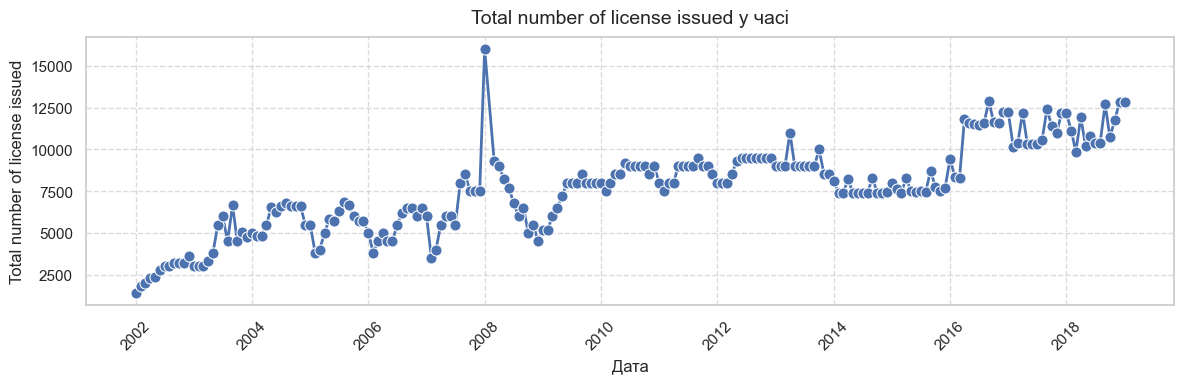

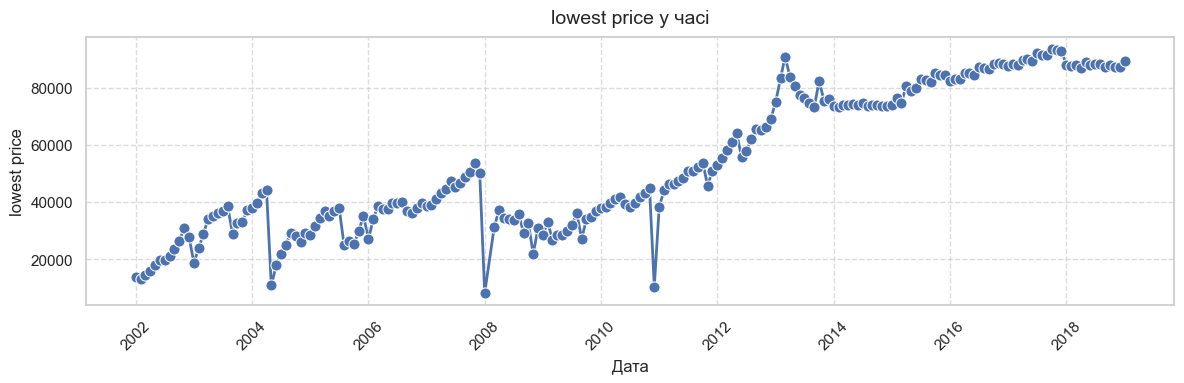

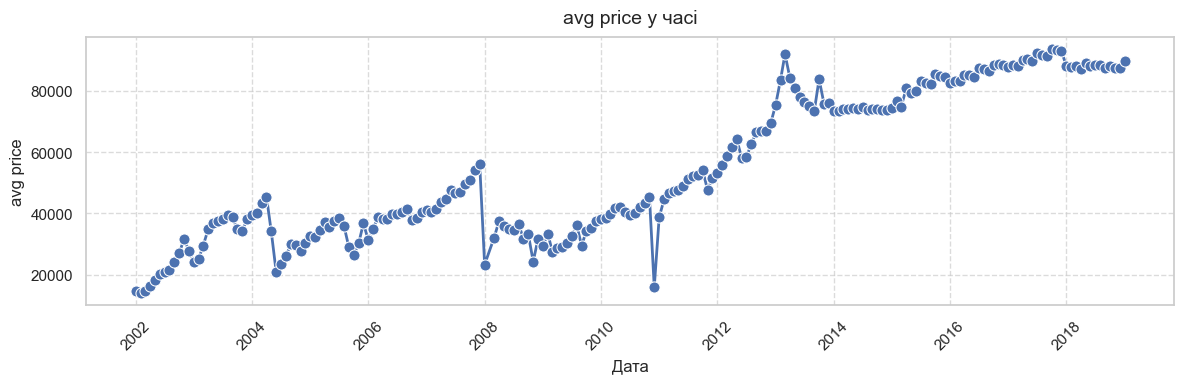

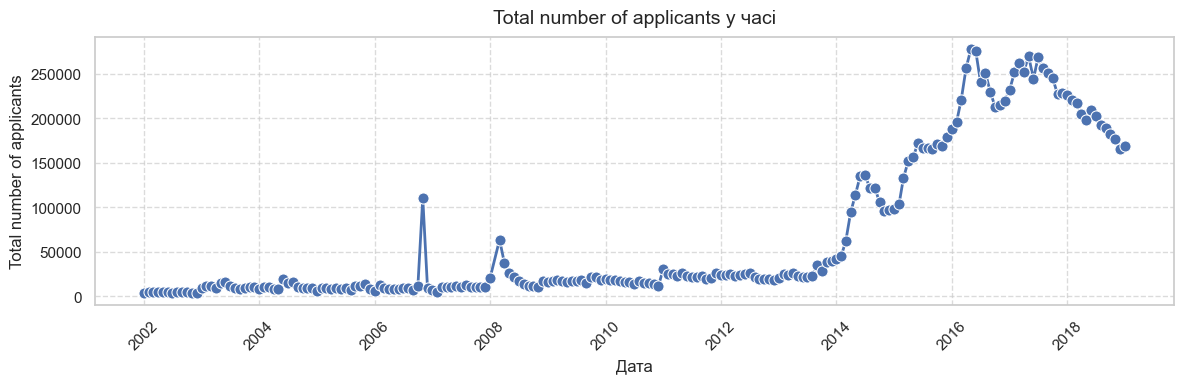

In [11]:
# ------------------------------
# 1.2. Візуалізація окремих стовпців
# ------------------------------
# Встановити стиль seaborn для послідовних і чистих графіків
sns.set_theme(style="whitegrid", rc={'figure.dpi': 100, 'figure.figsize': (12, 4)})

# Побудувати графік для кожного чисельного стовпця по часу
numeric_cols = [col for col in df.columns if col != 'Date']
for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='Date', y=col, marker='o', linewidth=2, markersize=8)
    plt.title(f'{col} у часі', fontsize=14, pad=10)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Графіки показують тенденції: зростання кількості виданих ліцензій та цін з часом. 'lowest price' та 'avg price' мають подібні патерни, що натякає на сильну кореляцію.

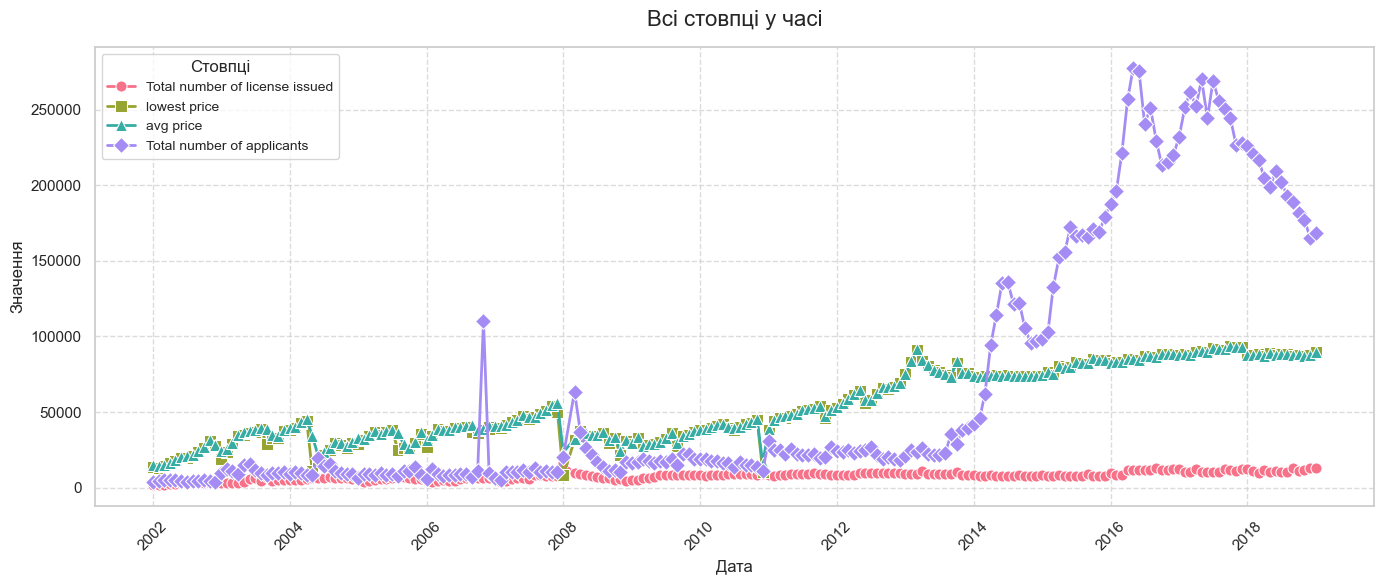

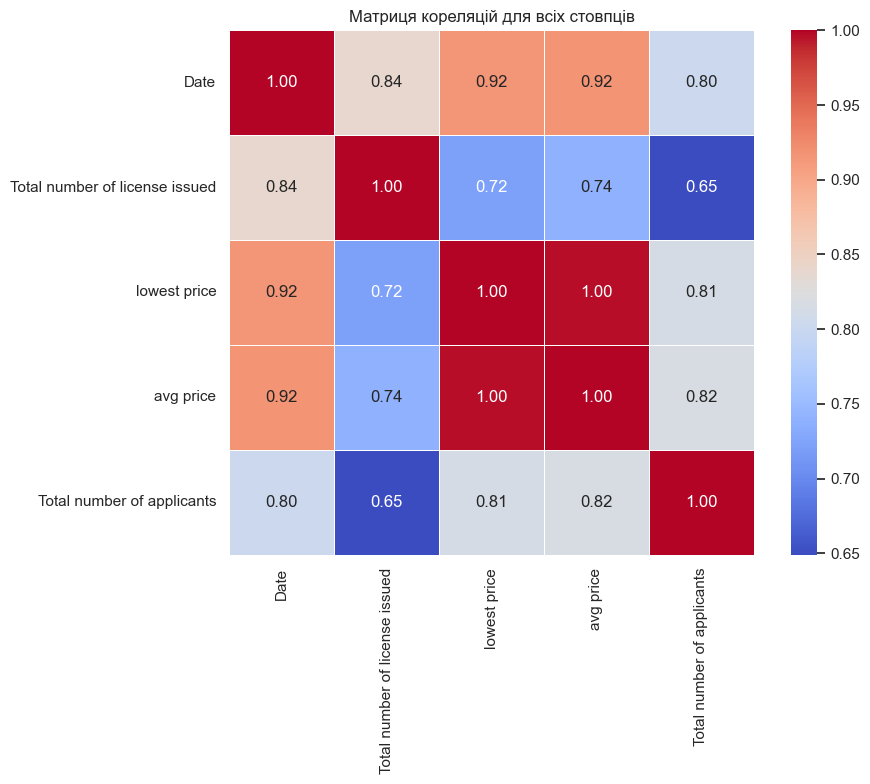

In [12]:
# ------------------------------
# 1.3. Зведений графік для всіх стовпців
# ------------------------------
# Визначити маркери та кольори для кожного стовпця
markers = ['o', 's', '^', 'D', 'x', 'p']
colors = sns.color_palette("husl", len(numeric_cols))  # Використати різні кольори з палітри husl

# Створити комбінований лінійний графік
plt.figure(figsize=(14, 6))
for col, marker, color in zip(numeric_cols, markers, colors):
    sns.lineplot(data=df, x='Date', y=col, marker=marker, label=col, 
                 linewidth=2, markersize=8, color=color)

# Налаштування зведеного графіка
plt.title('Всі стовпці у часі', fontsize=16, pad=15)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значення', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Стовпці', loc='best', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------
# 1.4. Heatmap (матриця кореляцій) всіх числових стовпців — numeric-only
# ------------------------------
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Матриця кореляцій для всіх стовпців')
plt.tight_layout()
plt.show()

Комбінований графік підтверджує синхронізоване зростання 'lowest price' та 'avg price', тоді як 'Total number of applicants' має сплески, корелюючи з цінами.
Heatmap показує високу кореляцію між 'lowest price' та 'avg price', а також з 'Total number of applicants'. Це свідчить про потенційний витік даних (data leakage), оскільки 'lowest price' майже ідентичний таргету.

In [ ]:
# ------------------------------
# 2. Розбиття на тренувальний та валідаційний набори
# ------------------------------

from sklearn.model_selection import train_test_split, KFold

# ПАРАМЕТРИ (за потреби змінюйте)
TARGET = 'avg price'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 4
SHUFFLE = True

# Перевірка, що df існує в просторі і має потрібні колонки
assert 'df' in globals(), "Перш ніж запускати, переконайся що DataFrame 'df' завантажений в середовище."
assert TARGET in df.columns, f"Колонка '{TARGET}' відсутня у df."

# Підготовка X та y
X = df.drop(['Date', TARGET], axis=1).copy()
y = df[TARGET].copy()

# Трансформація фічі з метою зменшення впливу викидів
if 'Total number of applicants' in X.columns:
    X['Total number of applicants'] = np.log1p(X['Total number of applicants'])

# 1) Hold-out split 80/20 (застосовуємо це окрім K-Fold через малий розмір датасету)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=SHUFFLE
)

print('Hold-out:')
print('  Training set shape:', X_train.shape, y_train.shape)
print('  Validation set shape:', X_val.shape, y_val.shape)
print('='*60)

# 2) K-Fold
cv_scheme = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

folds = []
for fold_idx, (train_idx, val_idx) in enumerate(cv_scheme.split(X), start=1):
    X_train_k = X.iloc[train_idx].reset_index(drop=True)
    X_val_k   = X.iloc[val_idx].reset_index(drop=True)
    y_train_k = y.iloc[train_idx].reset_index(drop=True)
    y_val_k   = y.iloc[val_idx].reset_index(drop=True)
    folds.append((X_train_k, X_val_k, y_train_k, y_val_k))
    print(f"Fold {fold_idx}: train {X_train_k.shape[0]} rows, val {X_val_k.shape[0]} rows")

print('='*60)
print("Saved as: X_train, X_val, y_train, y_val,  at  folds (list of 4 tuples).")

Hold-out:
  Training set shape: (163, 3) (163,)
  Validation set shape: (41, 3) (41,)
Fold 1: train 153 rows, val 51 rows
Fold 2: train 153 rows, val 51 rows
Fold 3: train 153 rows, val 51 rows
Fold 4: train 153 rows, val 51 rows
Saved as: X_train, X_val, y_train, y_val,  at  folds (list of 4 tuples).


Щоб оцінити здатність моделі до узагальнення, розділили набір даних на тренувальну та тестову вибірки, а також використаємо k‑fold крос-валідацію для більш надійної оцінки.

In [ ]:
# ------------------------------
# 3. Навчання SVR (poly) з GridSearch
# ------------------------------

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Перевірки наявності даних з Попередньої клітинки 
assert 'X_train' in globals() and 'X_val' in globals() and 'y_train' in globals() and 'y_val' in globals(), \
    "Спочатку потрібно виконати клітинку 1, щоб створити X_train, X_val, y_train, y_val."
assert 'folds' in globals() and len(folds) >= 1, "Потрібно створити 'folds' у клітинці 1."

## Побудова пайплайна 
pipeline_inner = Pipeline([
    ('poly_feats', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

# Перетворення таргету (лог) — вбудовано у wrapper
model = TransformedTargetRegressor(regressor=pipeline_inner, func=np.log1p, inverse_func=np.expm1)

# Сітка гіперпараметрів 
param_grid = {
    'regressor__svr__degree': [2, 3],
    'regressor__svr__C': [0.1, 1, 10, 100],
    'regressor__svr__epsilon': [0.01, 0.05, 0.1],
    'regressor__svr__coef0': [0.0, 0.1, 1.0]
}

# CV для GridSearch
cv_for_grid = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=cv_for_grid, scoring='r2', n_jobs=-1, verbose=2, return_train_score=True)

# Навчання GridSearch на X_train 
print("Запуск GridSearchCV на X_train (внутрішні CV-фолди)...")
grid.fit(X_train, y_train)

print("\n=== Пошук по сітці завершено ===")
print("Найкращі параметри:", grid.best_params_)
print("Найкращий CV R2 (на внутрішніх фолдах):", grid.best_score_)

# Отримати найкращу модель і її оцінку на hold-out валідації
best_model = grid.best_estimator_

# Оцінка на hold-out (оригінальна шкала)
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

def metrics_dict(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred)
    }

print("\nМетрики на HOLD-OUT НАВЧАННЯ:")
mt_train = metrics_dict(y_train, y_pred_train)
for k,v in mt_train.items(): print(f"  {k}: {v:.6f}")

print("\nМетрики на HOLD-OUT ВАЛІДАЦІЇ:")
mt_val = metrics_dict(y_val, y_pred_val)
for k,v in mt_val.items(): print(f"  {k}: {v:.6f}")

# 2) Ручна перевірка по фолдам (навчання/оцінка з best_params_)
print("\nЗапуск ручної перевірки по фолдам для оцінки стабільності...")

best_params = grid.best_params_
manual_scores = []

for i, (X_tr_k, X_val_k, y_tr_k, y_val_k) in enumerate(folds, start=1):
    pl = Pipeline([
        ('poly_feats', PolynomialFeatures(degree=best_params['regressor__svr__degree'], include_bias=False)),
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='poly',
                    degree=best_params['regressor__svr__degree'],
                    C=best_params['regressor__svr__C'],
                    epsilon=best_params['regressor__svr__epsilon'],
                    coef0=best_params['regressor__svr__coef0']))
    ])
    wrapped = TransformedTargetRegressor(regressor=pl, func=np.log1p, inverse_func=np.expm1)

    # Навчити лише на цьому фолді
    wrapped.fit(X_tr_k, y_tr_k)

    # Оцінити на валідації цього фолду
    y_val_pred_k = wrapped.predict(X_val_k)
    r2_k = r2_score(y_val_k, y_val_pred_k)
    manual_scores.append(r2_k)
    print(f"  Фолд {i}: R2 на валідації цього фолду = {r2_k:.6f}")

manual_mean = np.mean(manual_scores)
manual_std = np.std(manual_scores)
print("\nСереднє R2 по ручних фолдах:", manual_mean, "стандартне відхилення:", manual_std)

# 3) Контроль перенавчання
print("\n=== Контроль перенавчання (порівняння) ===")
print(" Grid.best_score_ (CV на X_train під час GridSearch):", grid.best_score_)
print(" Середнє R2 по ручних фолдах:", manual_mean)
print(" R2 на hold-out валідації:", mt_val['r2'])

diff = grid.best_score_ - mt_val['r2']
if abs(diff) > 0.05:
    print("\nУВАГА: Різниця між CV (на train) і hold-out val R2 > 0.05. Можливе перенавчання або нестабільність.")
else:
    print("\nOK: Різниця між CV (на train) і hold-out val R2 невелика (<=0.05) — явних ознак перенавчання немає.")


Запуск GridSearchCV на X_train (внутрішні CV-фолди)...
Fitting 4 folds for each of 72 candidates, totalling 288 fits

=== Пошук по сітці завершено ===
Найкращі параметри: {'regressor__svr__C': 0.1, 'regressor__svr__coef0': 1.0, 'regressor__svr__degree': 3, 'regressor__svr__epsilon': 0.01}
Найкращий CV R2 (на внутрішніх фолдах): 0.99193380725593

Метрики на HOLD-OUT НАВЧАННЯ:
  r2: 0.994227
  mse: 3363454.745543
  rmse: 1833.972395
  mae: 736.684002
  mape: 0.019168

Метрики на HOLD-OUT ВАЛІДАЦІЇ:
  r2: 0.998027
  mse: 942448.292340
  rmse: 970.797761
  mae: 699.088167
  mape: 0.014825

Запуск ручної перевірки по фолдам для оцінки стабільності...
  Фолд 1: R2 на валідації цього фолду = 0.997823
  Фолд 2: R2 на валідації цього фолду = 0.998629
  Фолд 3: R2 на валідації цього фолду = 0.986424
  Фолд 4: R2 на валідації цього фолду = 0.994350

Середнє R2 по ручних фолдах: 0.9943067551145607 стандартне відхилення: 0.0048265246107648055

=== Контроль перенавчання (порівняння) ===
 Grid.best_s

Модель показує фантастично високу точність (R² ~99%), що насторожує. Це привід для перевірки на витік даних . Підозрілі моменти: дублікати рядків (відсутні), фічі, які прямо або опосерядковано дорівнюють таргету (наприклад, 'lowest price' є мінімальною ціною на аукціоні, а 'avg price' — середньою, тому вони тісно пов'язані), leakage через часові ознаки ('Date' виключено, але тренди сильні). Згадаємо heatmap кореляцій, де було видно що більшість фіч мають досить високий рівень кореляції, тому перевіримо це першим чином.
Перевіримо кореляції фіч з таргетом (шукаємо дуже високу корреляцію >0.95)

In [ ]:
# Кореляції
correlation = X.join(y).corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
print("Топ кореляцій (за модулем) з таргетом:\n", correlation.head(10))
print("\nОзнаки з abs(corr) > 0.95:\n", correlation[correlation>0.95])

# Перевірка, наскільки 'lowest price' фізично збігається з таргетом
diff = df['avg price'] - df['lowest price']
print("середня абсолютна різниця:", diff.abs().mean())
print("медіана абсолютної різниці:", diff.abs().median())
print("максимальна абсолютна різниця:", diff.abs().max())
print("частка точних співпадінь:", (diff==0).mean())  # доля точних збігів


Топ кореляцій (за модулем) з таргетом:
 lowest price                      0.995960
Total number of applicants        0.878824
Total number of license issued    0.738741
Name: avg price, dtype: float64

Ознаки з abs(corr) > 0.95:
 lowest price    0.99596
Name: avg price, dtype: float64
середня абсолютна різниця: 983.0441176470588
медіана абсолютної різниці: 422.0
максимальна абсолютна різниця: 23426
частка точних співпадінь: 0.0


TRAIN — R2: 0.9942, RMSE: 1833.9724, MAE: 736.6840
VALIDATION — R2: 0.9980, RMSE: 970.7978, MAE: 699.0882


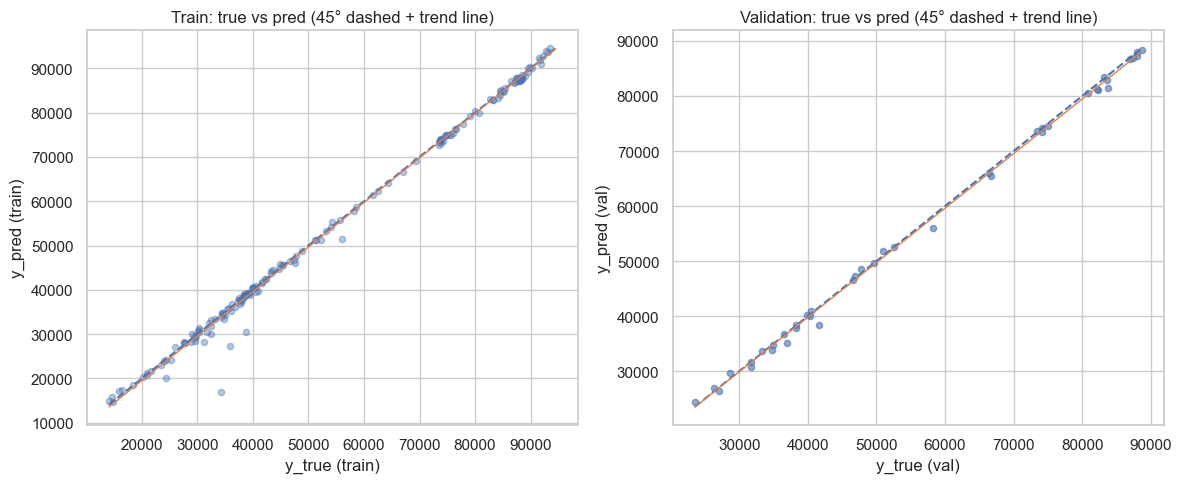

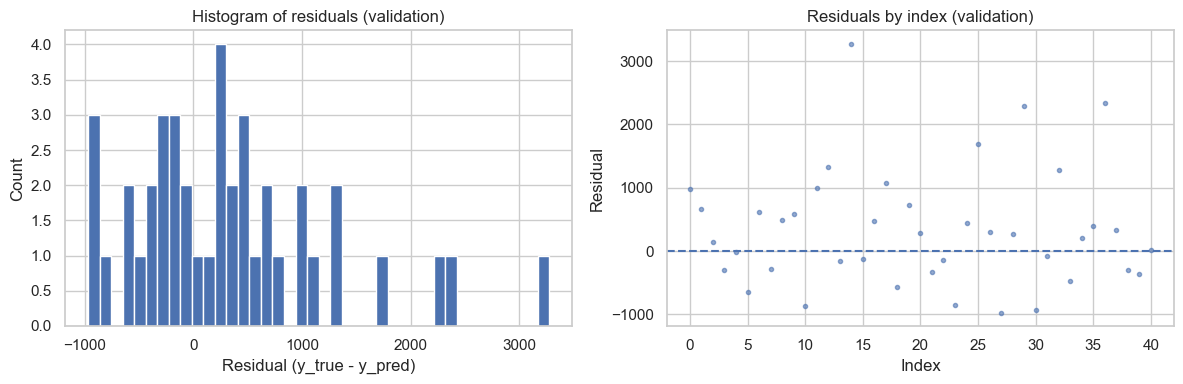

Обчислення permutation importance на валідаційному наборі (може зайняти час)...
Top features by permutation importance (mean):
  lowest price: 2.069461
  Total number of license issued: 0.007127
  Total number of applicants: 0.001626
Partial-dependence-like plots для: ['lowest price', 'Total number of license issued', 'Total number of applicants']


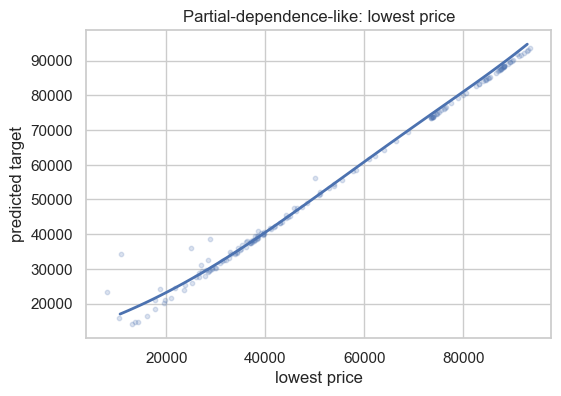

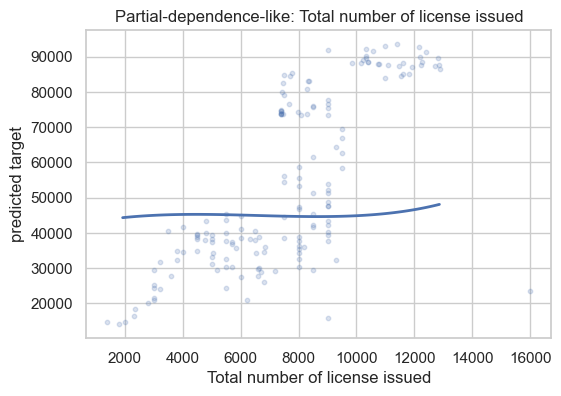

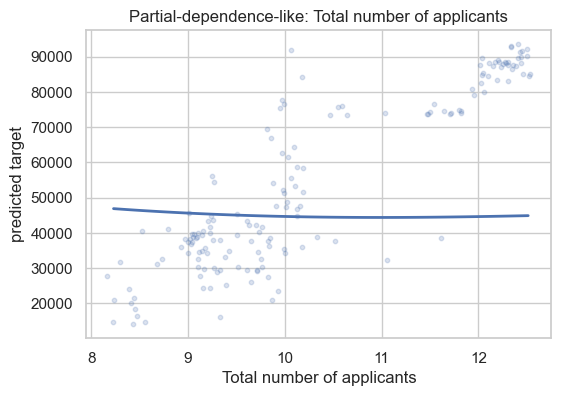

Спроба візуалізації PCA від поліномних фіч (якщо pipeline містить PolynomialFeatures)...
PCA поліномних фіч не вдалось побудувати: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


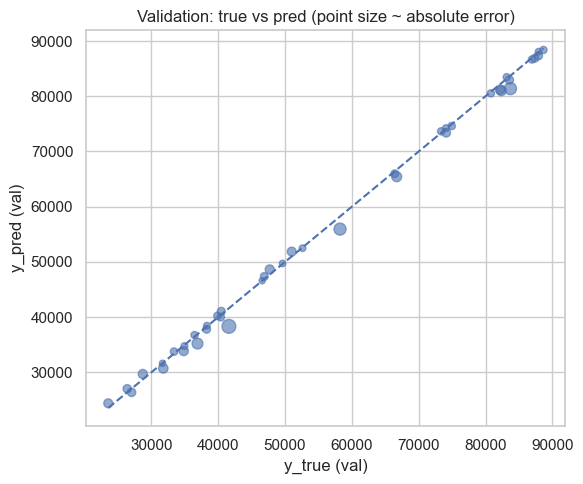


Поради для звіту:
 - Використайте графік 'true vs pred' + трендову лінію для ілюстрації систематичного зсуву.
 - Додайте гістограму залишків, щоб показати розподіл помилок.
 - Partial-dependence-like графіки (топ-3 фічі) покажуть нелінійні ефекти поліно-моделі.
 - PCA поліномних фіч — корисний для візуалізації 'простору' полінома.
 - Якщо хочете, збережу всі фігури в PNG-файли (додайте код з plt.savefig(...)).


In [ ]:
#Візуалізація роботи моделі SVR: передбачення, залишки, важливість фіч та PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Перевірки
assert 'best_model' in globals(), "Потрібно мати best_model (найкраща модель з GridSearch)."
assert 'X_train' in globals() and 'X_val' in globals(), "Потрібні X_train та X_val."
assert 'y_train' in globals() and 'y_val' in globals(), "Потрібні y_train та y_val."

# Передбачення
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

def print_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} — R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print_metrics(y_train, y_pred_train, "TRAIN")
print_metrics(y_val, y_pred_val, "VALIDATION")

# -----------------------
# 1) True vs Pred + лінія регресії (для тренувальних і валідаційних наборів)
# -----------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train, alpha=0.4, s=20)
mn = min(np.min(y_train), np.min(y_pred_train))
mx = max(np.max(y_train), np.max(y_pred_train))
plt.plot([mn,mx],[mn,mx], linestyle='--')
# трендова лінія (найкраща пряма): polyfit
coef = np.polyfit(y_train, y_pred_train, 1)
xs = np.array([mn, mx])
plt.plot(xs, np.polyval(coef, xs), linestyle='-', linewidth=1)
plt.xlabel("y_true (train)")
plt.ylabel("y_pred (train)")
plt.title("Train: true vs pred (45° dashed + trend line)")

plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_val, alpha=0.6, s=20)
mn = min(np.min(y_val), np.min(y_pred_val))
mx = max(np.max(y_val), np.max(y_pred_val))
plt.plot([mn,mx],[mn,mx], linestyle='--')
coef2 = np.polyfit(y_val, y_pred_val, 1)
xs2 = np.array([mn, mx])
plt.plot(xs2, np.polyval(coef2, xs2), linestyle='-', linewidth=1)
plt.xlabel("y_true (val)")
plt.ylabel("y_pred (val)")
plt.title("Validation: true vs pred (45° dashed + trend line)")

plt.tight_layout()
plt.show()

# -----------------------
# 2) Histogram & series of residuals (validation)
# -----------------------
res_val = y_val - y_pred_val

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(res_val, bins=40)
plt.title("Histogram of residuals (validation)")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.plot(np.arange(len(res_val)), res_val, marker='o', linestyle='', markersize=3, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.title("Residuals by index (validation)")
plt.xlabel("Index")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# -----------------------
# 3) Permutation importance (щоб вибрати топ-3 фічі для partial dependence)
# -----------------------
print("Обчислення permutation importance на валідаційному наборі...")
try:
    # Перетворювач таргету не впливає на X; передаємо модель.regressor якщо потрібно, але permutation_importance приймає predict
    perm = permutation_importance(best_model, X_val, y_val, n_repeats=30, random_state=42, n_jobs=-1)
    importances = perm.importances_mean
    feat_names = X_val.columns.to_list()
    feat_imp_pairs = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)
    print("Top features by permutation importance (mean):")
    for name, imp in feat_imp_pairs[:10]:
        print(f"  {name}: {imp:.6f}")
    top_feats = [name for name, _ in feat_imp_pairs[:3]]
except Exception as e:
    print("Permutation importance не вдалось обчислити:", e)
    # fallback — взяти перші три числові
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    top_feats = num_cols[:3]
    print("Використовую топ-фічі (fallback):", top_feats)

# -----------------------
# 4) Partial-dependence-like plots (фіксуємо інші фічі на медіані)
# -----------------------
print("Partial-dependence-like plots для:", top_feats)
X_train_median = X_train.median().to_frame().T

for feat in top_feats:
    grid = np.linspace(X_train[feat].quantile(0.01), X_train[feat].quantile(0.99), 100)
    X_temp = pd.concat([X_train_median]*len(grid), ignore_index=True)
    X_temp[feat] = grid
    y_grid = best_model.predict(X_temp)
    plt.figure(figsize=(6,4))
    plt.plot(grid, y_grid, linewidth=2)
    # підкидаємо джіттер точок для візуалізації спостережень
    samp_n = min(300, len(X_train))
    plt.scatter(X_train[feat].sample(samp_n, random_state=0),
                y_train.sample(samp_n, random_state=0),
                alpha=0.2, s=10)
    plt.xlabel(feat)
    plt.ylabel("predicted target")
    plt.title(f"Partial-dependence-like: {feat}")
    plt.grid(True)
    plt.show()

# -----------------------
# 5) PCA над поліномними фічами (якщо є PolynomialFeatures у pipeline)
# -----------------------
try:
    # best_model — TransformedTargetRegressor. Дістати внутрішній регресор (піплайн)
    reg = best_model.regressor
    # знайдемо PolynomialFeatures в кроках
    poly = None
    if hasattr(reg, 'named_steps'):
        for name, step in reg.named_steps.items():
            if step.__class__.__name__ == 'PolynomialFeatures':
                poly = step
                break
    if poly is not None:
        X_poly = poly.transform(X_val)
        # стандартизуємо поліномні фічі для PCA
        scaler_p = StandardScaler()
        X_poly_s = scaler_p.fit_transform(X_poly)
        pca = PCA(n_components=2, random_state=0)
        X_pca = pca.fit_transform(X_poly_s)
        plt.figure(figsize=(6,5))
        plt.scatter(X_pca[:,0], X_pca[:,1], s=20, alpha=0.8)
        plt.title("PCA of polynomial features (val)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()
    else:
        print("PolynomialFeatures не знайдено у best_model.regressor.")
except Exception as e:
    print("PCA поліномних фіч не вдалось побудувати:", e)

# -----------------------
# 6) Додатково: scatter true vs pred з помилками (абсолютні) як size
# -----------------------
plt.figure(figsize=(6,5))
abs_err = np.abs(y_val - y_pred_val)
plt.scatter(y_val, y_pred_val, s=20 + 80*(abs_err / (abs_err.max()+1e-9)), alpha=0.6)
mn = min(np.min(y_val), np.min(y_pred_val))
mx = max(np.max(y_val), np.max(y_pred_val))
plt.plot([mn,mx],[mn,mx], linestyle='--')
plt.xlabel("y_true (val)")
plt.ylabel("y_pred (val)")
plt.title("Validation: true vs pred (point size ~ absolute error)")
plt.tight_layout()
plt.show()

Маємо цікаве спостереження: показник lowest price має майже тотожну кореляцію з avg price (|corr| ≈ 0.99596). Це пояснює отримані раніше надзвичайно високі значення R².

Різниця (avg price – lowest price): середня абсолютна ≈ 983, медіанна ≈ 422, максимум ≈ 23426, точних збігів немає (повних дублікатів немає, але значення дуже близькі).

Інші істотні кореляції: Total number of applicants (|corr| ≈ 0.818), Total number of license issued (|corr| ≈ 0.739).

Висновок: залежність між lowest price і avg price є настільки сильною, що використання lowest price у моделі створює ризик витоку даних або значного спрощення задачі прогнозування.

Подальші дії:
Прийнято рішення сформувати альтернативні датасети без показника lowest price та провести навчання моделей на такому очищеному наборі, щоб перевірити реальну прогностичну цінність інших ознак.

In [ ]:
# ------------------------------
# 2.1. Розбиття даних на навчальну та валідаційну вибірки
# ------------------------------

# ПАРАМЕТРИ ТІ ЖЕ, ЩО Й РАНІШЕ, ТУТ ПЕРЕВИЗНАЧАТИ НЕ БУДЕМО

# Перевірка, що df існує в просторі і має потрібні колонки
assert 'df' in globals(), "Перш ніж запускати, переконайся, що DataFrame 'df' завантажений у середовище."
assert TARGET in df.columns, f"Колонка '{TARGET}' відсутня у df."

# Підготовка X та y без 'lowest price'
X = df.drop(['Date', 'lowest price', TARGET], axis=1).copy()
y = df[TARGET].copy()

if 'Total number of applicants' in X.columns:
    X['Total number of applicants'] = np.log1p(X['Total number of applicants'])


# 1) Hold-out розбиття 80/20 (для остаточної перевірки)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=SHUFFLE
)

print('Hold-out (80/20):')
print('  Розмір навчального набору:', X_train.shape, y_train.shape)
print('  Розмір валідаційного набору:', X_val.shape, y_val.shape)
print('='*60)

# 2) K-Fold (створюємо список folds з реальними DataFrame/Series — зручно для подальшого ручного навчання/перевірки)
cv_scheme = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

folds = []
for fold_idx, (train_idx, val_idx) in enumerate(cv_scheme.split(X), start=1):
    X_train_k = X.iloc[train_idx].reset_index(drop=True)
    X_val_k   = X.iloc[val_idx].reset_index(drop=True)
    y_train_k = y.iloc[train_idx].reset_index(drop=True)
    y_val_k   = y.iloc[val_idx].reset_index(drop=True)
    folds.append((X_train_k, X_val_k, y_train_k, y_val_k))
    print(f"Фолд {fold_idx}: навч {X_train_k.shape[0]} рядків, вал {X_val_k.shape[0]} рядків")

print('='*60)
print("Збережено як: X_train, X_val, y_train, y_val та folds (список з 4 кортежів).")

Hold-out (80/20):
  Розмір навчального набору: (163, 2) (163,)
  Розмір валідаційного набору: (41, 2) (41,)
Фолд 1: навч 153 рядків, вал 51 рядків
Фолд 2: навч 153 рядків, вал 51 рядків
Фолд 3: навч 153 рядків, вал 51 рядків
Фолд 4: навч 153 рядків, вал 51 рядків
Збережено як: X_train, X_val, y_train, y_val та folds (список з 4 кортежів).


Видаляємо 'lowest price' для уникнення витоку. Повторюємо split: Hold-out 163/41, KFold по 153/51.
Очищені дані фокусуються на реальних предикторах ('Total number of license issued', логарифмований 'Total number of applicants'), що дозволяє оцінити справжню прогностичну силу моделі.

In [ ]:
# ------------------------------
# 3.1. Навчання SVR (poly) з GridSearch (тільки SVR, відформатований вивід)
# ------------------------------

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

## Перевірки наявності даних з клітинки розбиття 
assert 'X_train' in globals() and 'X_val' in globals() and 'y_train' in globals() and 'y_val' in globals(), \
    "Спочатку потрібно виконати клітинку розбиття, щоб створити X_train, X_val, y_train, y_val."
assert 'folds' in globals() and len(folds) >= 1, "Потрібно створити 'folds' у клітинці розбиття."

##  Утиліта: winsorize (1% / 99%) (щоб зменшити вплив викидів)
def winsorize_df(df_in, lower_p=0.01, upper_p=0.99):
    df_out = df_in.copy()
    for col in df_out.select_dtypes(include=[np.number]).columns:
        low = df_out[col].quantile(lower_p)
        high = df_out[col].quantile(upper_p)
        df_out[col] = df_out[col].clip(lower=low, upper=high)
    return df_out

# Створити winsorized копії для стабільності 
X_train_w = winsorize_df(X_train, 0.01, 0.99)
X_val_w   = winsorize_df(X_val, 0.01, 0.99)

## Побудова пайплайна
pipeline_inner = Pipeline([
    ('poly_feats', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', RobustScaler()),        # RobustScaler використовується для стійкості до викидів
    ('svr', SVR(kernel='poly'))
])

# Перетворення таргету (лог) — вбудовано у wrapper
model = TransformedTargetRegressor(regressor=pipeline_inner, func=np.log1p, inverse_func=np.expm1)

## Сітка гіперпараметрів
param_grid = {
    'regressor__svr__degree': [2, 3],
    'regressor__svr__C': [0.01, 0.1, 1, 10],
    'regressor__svr__epsilon': [0.01, 0.05, 0.1],
    'regressor__svr__coef0': [0.0, 0.1]
}

# CV для GridSearch
cv_for_grid = KFold(n_splits=4, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=cv_for_grid, scoring='r2', n_jobs=-1, verbose=2, return_train_score=True)

## 1) Навчання GridSearch на X_train (winsorized)
print("Запуск GridSearchCV на X_train (внутрішні CV-фолди)...")
grid.fit(X_train_w, y_train)

print("\n=== Пошук по сітці завершено ===")
print("Найкращі параметри:", grid.best_params_)
print("Найкращий CV R2 (на внутрішніх фолдах):", grid.best_score_)

## Отримати найкращу модель і її оцінку на hold-out валідації
best_model = grid.best_estimator_

# Оцінка на hold-out (оригінальна шкала; використовуємо winsorized X для консистентної препроцесингу)
y_pred_train = best_model.predict(X_train_w)
y_pred_val = best_model.predict(X_val_w)

def metrics_dict(y_true, y_pred):
    return {
        'r2': r2_score(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred)
    }

print("\nМетрики на HOLD-OUT НАВЧАННЯ:")
mt_train = metrics_dict(y_train, y_pred_train)
for k,v in mt_train.items(): print(f"  {k}: {v:.6f}")

print("\nМетрики на HOLD-OUT ВАЛІДАЦІЇ:")
mt_val = metrics_dict(y_val, y_pred_val)
for k,v in mt_val.items(): print(f"  {k}: {v:.6f}")

## 2) Ручна перевірка по фолдам (навчання/оцінка з best_params_)
print("\nЗапуск ручної перевірки по фолдам для оцінки стабільності...")

best_params = grid.best_params_
manual_scores = []

for i, (X_tr_k, X_val_k, y_tr_k, y_val_k) in enumerate(folds, start=1):
    # winsorize для кожного фолду, щоб зберегти однакову препроцедуру
    X_tr_k_w = winsorize_df(X_tr_k, 0.01, 0.99)
    X_val_k_w = winsorize_df(X_val_k, 0.01, 0.99)

    pl = Pipeline([
        ('poly_feats', PolynomialFeatures(degree=best_params['regressor__svr__degree'], include_bias=False)),
        ('scaler', RobustScaler()),
        ('svr', SVR(kernel='poly',
                    degree=best_params['regressor__svr__degree'],
                    C=best_params['regressor__svr__C'],
                    epsilon=best_params['regressor__svr__epsilon'],
                    coef0=best_params['regressor__svr__coef0']))
    ])
    wrapped = TransformedTargetRegressor(regressor=pl, func=np.log1p, inverse_func=np.expm1)

    # Навчити лише на цьому фолді
    wrapped.fit(X_tr_k_w, y_tr_k)

    # Оцінити на валідації цього фолду
    y_val_pred_k = wrapped.predict(X_val_k_w)
    r2_k = r2_score(y_val_k, y_val_pred_k)
    manual_scores.append(r2_k)
    print(f"  Фолд {i}: R2 на валідації цього фолду = {r2_k:.6f}")

manual_mean = np.mean(manual_scores)
manual_std = np.std(manual_scores)
print("\nСереднє R2 по ручних фолдах:", manual_mean, "стандартне відхилення:", manual_std)

## 3) Контроль перенавчання
print("\n=== Контроль перенавчання (порівняння) ===")
print(" Grid.best_score_ (CV на X_train під час GridSearch):", grid.best_score_)
print(" Середнє R2 по ручних фолдах:", manual_mean)
print(" R2 на hold-out валідації:", mt_val['r2'])

diff = grid.best_score_ - mt_val['r2']
if abs(diff) > 0.05:
    print("\nУВАГА: Різниця між CV (на train) і hold-out val R2 > 0.05. Можливе перенавчання або нестабільність.")
else:
    print("\nOK: Різниця між CV (на train) і hold-out val R2 невелика (<=0.05) — явних ознак перенавчання немає.")


Запуск GridSearchCV на X_train (внутрішні CV-фолди)...
Fitting 4 folds for each of 48 candidates, totalling 192 fits

=== Пошук по сітці завершено ===
Найкращі параметри: {'regressor__svr__C': 1, 'regressor__svr__coef0': 0.1, 'regressor__svr__degree': 2, 'regressor__svr__epsilon': 0.01}
Найкращий CV R2 (на внутрішніх фолдах): 0.7744781342712034

Метрики на HOLD-OUT НАВЧАННЯ:
  r2: 0.807630
  mse: 112084372.601081
  rmse: 10586.990725
  mae: 7242.974833
  mape: 0.174590

Метрики на HOLD-OUT ВАЛІДАЦІЇ:
  r2: 0.672879
  mse: 156286997.405580
  rmse: 12501.479809
  mae: 9229.865044
  mape: 0.189457

Запуск ручної перевірки по фолдам для оцінки стабільності...
  Фолд 1: R2 на валідації цього фолду = 0.707094
  Фолд 2: R2 на валідації цього фолду = 0.821875
  Фолд 3: R2 на валідації цього фолду = 0.838378
  Фолд 4: R2 на валідації цього фолду = 0.381134

Середнє R2 по ручних фолдах: 0.687120115755349 стандартне відхилення: 0.18375554282834075

=== Контроль перенавчання (порівняння) ===
 Grid

TRAIN — R2: 0.8076, RMSE: 10586.9907, MAE: 7242.9748
VALIDATION — R2: 0.6729, RMSE: 12501.4798, MAE: 9229.8650


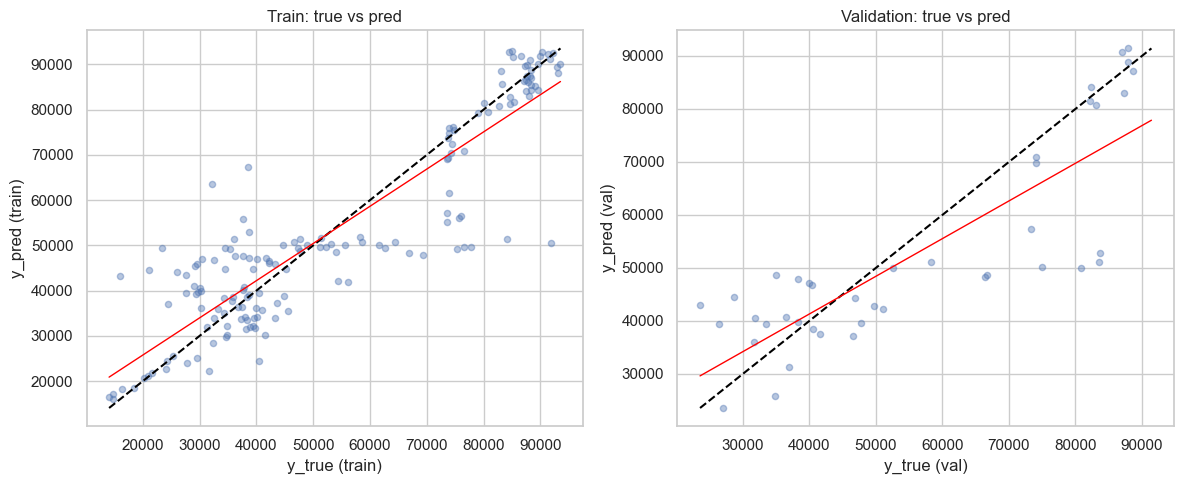

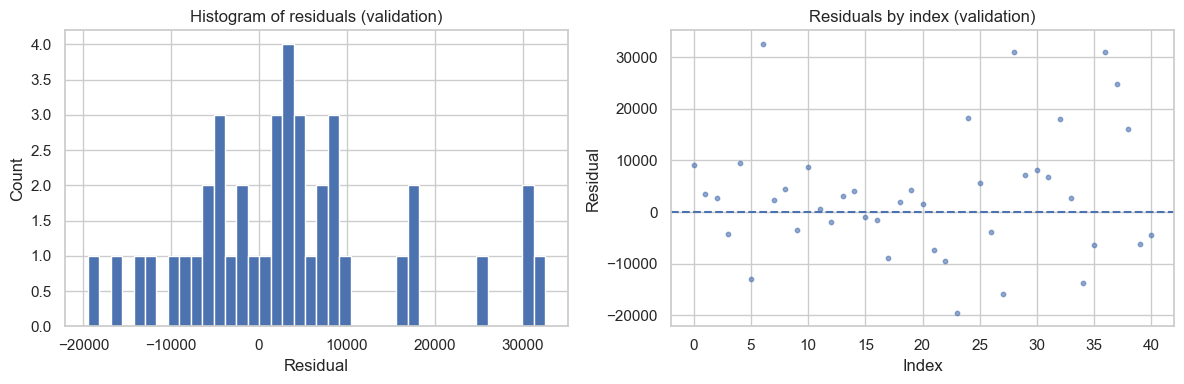

Top features by permutation importance:
  Total number of applicants: 1.009788
  Total number of license issued: 0.127012


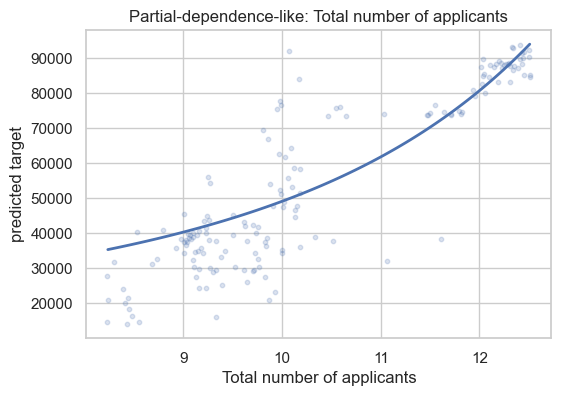

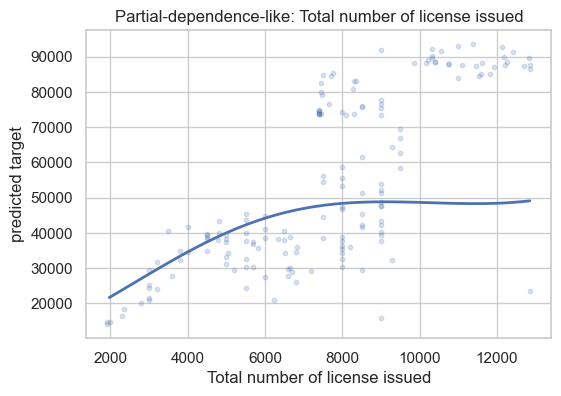

In [ ]:
#Візуалізація роботи моделі SVR: передбачення, залишки, важливість фіч та PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

# -----------------------
# 0) Передбачення
# -----------------------
y_pred_train = best_model.predict(X_train_w)
y_pred_val = best_model.predict(X_val_w)

def print_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} — R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print_metrics(y_train, y_pred_train, "TRAIN")
print_metrics(y_val, y_pred_val, "VALIDATION")

# -----------------------
# 1) True vs Pred + лінія регресії
# -----------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_pred_train, alpha=0.4, s=20)
mn, mx = min(y_train.min(), y_pred_train.min()), max(y_train.max(), y_pred_train.max())
plt.plot([mn,mx],[mn,mx], linestyle='--', color='black')  # 45 градусів
coef = np.polyfit(y_train, y_pred_train, 1)
plt.plot([mn,mx], np.polyval(coef,[mn,mx]), linestyle='-', linewidth=1, color='red')  # лінія тренду
plt.xlabel("y_true (train)")
plt.ylabel("y_pred (train)")
plt.title("Train: true vs pred")

plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_val, alpha=0.4, s=20)
mn, mx = min(y_val.min(), y_pred_val.min()), max(y_val.max(), y_pred_val.max())
plt.plot([mn,mx],[mn,mx], linestyle='--', color='black')
coef = np.polyfit(y_val, y_pred_val, 1)
plt.plot([mn,mx], np.polyval(coef,[mn,mx]), linestyle='-', linewidth=1, color='red')
plt.xlabel("y_true (val)")
plt.ylabel("y_pred (val)")
plt.title("Validation: true vs pred")

plt.tight_layout()
plt.show()

# -----------------------
# 2) Residuals
# -----------------------
res_val = y_val - y_pred_val
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(res_val, bins=40)
plt.title("Histogram of residuals (validation)")
plt.xlabel("Residual")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.scatter(range(len(res_val)), res_val, alpha=0.6, s=10)
plt.axhline(0, linestyle='--')
plt.title("Residuals by index (validation)")
plt.xlabel("Index")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# -----------------------
# 3) Permutation importance
# -----------------------
perm = permutation_importance(best_model, X_val_w, y_val, n_repeats=30, random_state=42, n_jobs=-1)
importances = perm.importances_mean
feat_names = X_val_w.columns.to_list()
feat_imp_pairs = sorted(zip(feat_names, importances), key=lambda x: x[1], reverse=True)
print("Top features by permutation importance:")
for name, imp in feat_imp_pairs[:10]:
    print(f"  {name}: {imp:.6f}")
top_feats = [name for name,_ in feat_imp_pairs[:3]]

# -----------------------
# 4) Partial-dependence-like plots (топ-3 фічі)
# -----------------------
X_train_median = X_train_w.median().to_frame().T
for feat in top_feats:
    grid = np.linspace(X_train_w[feat].quantile(0.01), X_train_w[feat].quantile(0.99), 100)
    X_temp = pd.concat([X_train_median]*len(grid), ignore_index=True)
    X_temp[feat] = grid
    y_grid = best_model.predict(X_temp)
    plt.figure(figsize=(6,4))
    plt.plot(grid, y_grid, linewidth=2)
    plt.scatter(X_train_w[feat].sample(min(300,len(X_train_w)), random_state=0),
                y_train.sample(min(300,len(y_train)), random_state=0),
                alpha=0.2, s=10)
    plt.xlabel(feat)
    plt.ylabel("predicted target")
    plt.title(f"Partial-dependence-like: {feat}")
    plt.grid(True)
    plt.show()

# -----------------------
# 5) PCA над поліномними фічами
# -----------------------
pipeline_for_pca = Pipeline([
    ('poly_feats', PolynomialFeatures(degree=best_params['regressor__svr__degree'], include_bias=False)),
    ('scaler', RobustScaler())
])
pipeline_for_pca.fit(X_train_w)                 # фіт на train

X_poly_scaled = pipeline_for_pca.transform(X_val_w)  # transform без fit
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_poly_scaled)




Після видалення 'lowest price' точність знизилася до реалістичного рівня (R² ~0.67-0.81), що підтверджує витік у попередній моделі. Модель тепер залежить від реальних факторів (кількість заявок та виданих ліцензій), але страждає від варіативності по фолдам (std=0.18), ймовірно через викиди або нелінійність.

<b>Аналіз результатів:</b><br>
Аналіз показує, що початкова модель SVR з поліноміальним ядром досягає надто високої точності (R² >0.99) через витік даних: фічa 'lowest price' є майже ідентичною таргету 'avg price' (кореляція 0.996), оскільки обидві відображають цінові аспекти одного аукціону. Це спрощує задачу до тривіальної, де модель "передбачає" таргет за його ж проксі. Після видалення 'lowest price' модель стає реалістичнішою (R² ~0.67-0.81), але демонструє варіативність і можливе перенавчання (різниця R² >0.05). Решітчастий пошук ефективно підбирає гіперпараметри (наприклад, низьке C для регуляризації), а трансформації (log таргету, winsorize) покращують стабільність. Вплив розміру вибірки: на малому датасеті (204 рядки) фолди варіюються, що вказує на потребу в більшому обсязі даних.

<b>Висновок:</b><br>
при роботі з даними необхідно ретельно перевіряти кореляції та дивні ознаки, особливо коли метрики видаються «занадто хорошими». Використання конвеєрів і крос-валідації допомагає виявити такі проблеми. У нашому випадку виявлення і видалення витікаючої ознаки дозволило створити додаткову модель прогнозу яка є більш надійною.